### This notebook demonstrates the improvement of multi-sample analysis over per-sample analysis with ensemble trained with AGT

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import abstract_gradient_training as agt
import sklearn
import copy
import gurobipy as gp
from gurobipy import GRB
import json
from tqdm import tqdm
import random
import matplotlib.colors as mcolors

In [3]:
# dev = "cuda:1" if torch.cuda.is_available() else "cpu"
dev = "cpu"
device = torch.device(dev)
print(f"Using device: {device}")

Using device: cpu


In [28]:
# get data
ensemble_size = 5
"""Initialise the halfmoons training data."""
seed = 0
total_dataset_size = 50000
train_dataset_size_per_member = total_dataset_size // ensemble_size  # number of samples per batch
batch_size = train_dataset_size_per_member

test_size = 1000
# n_batches = 3  # number of batches per epoch
n_epochs = 4  # number of epochs

torch.manual_seed(seed)
# load the dataset
x, y = sklearn.datasets.make_moons(noise=0.1, n_samples=ensemble_size*train_dataset_size_per_member + test_size, random_state=seed)
# to make it easier to train, we'll space the moons out a bit and add some polynomial features
x[y==0, 1] += 0.2
x = np.hstack((x, x**2, (x[:, 0] * x[:, 1])[:, None], x**3))
# perform a test-train split
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=test_size, random_state=seed
)   

# convert into pytorch dataloaders
x_train, y_train = torch.from_numpy(x_train).float().to(device), torch.from_numpy(y_train).to(device)
x_test, y_test = torch.from_numpy(x_test).float().to(device), torch.from_numpy(y_test).to(device)
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)
dataset_test = torch.utils.data.TensorDataset(x_test, y_test)
# dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=250, shuffle=False)

In [29]:
"""Train an ensemble of classifiers on the AGT dataset."""
NOMINAL_CONFIG = agt.AGTConfig(
    learning_rate=3.0,
    n_epochs=4,
    device=dev,
    loss="cross_entropy",
    lr_decay=0.6,
    lr_min=1e-3,
    log_level="DEBUG",
    # paired_poison=True,
    clip_gamma=0.1,
)

ensemble = []
torch.manual_seed(seed)
indices = torch.randperm(len(dataset_train))
for t in range(ensemble_size):
    trained_models = []
    model_t = torch.nn.Sequential(
        torch.nn.Linear(7, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 2),
    ).to(device)
    # model_t = torch.nn.Sequential(torch.nn.Linear(7, 2).to(device))
    bounded_model_t = agt.bounded_models.IntervalBoundedModel(model_t)
    # create a disjoint subset of the training data
    dataset_train_t = torch.utils.data.Subset(dataset_train, indices[t::ensemble_size])  # type: ignore
    dataloader_t = torch.utils.data.DataLoader(dataset_train_t, batch_size=batch_size, shuffle=True)
    ensemble.append((bounded_model_t, dataloader_t))

#### TRAINING

In [30]:
gridsize = 100
test_size = gridsize ** 2

# define a grid of points and add features
x0 = torch.linspace(-1.5, 2.5, gridsize)
x1 = torch.linspace(-1.2, 2.2, gridsize)
X0, X1 = torch.meshgrid(x0, x1)
X0f, X1f = X0.flatten(), X1.flatten()
grid_data = torch.stack((X0f, X1f, X0f**2, X1f**2, X0f * X1f, X0f ** 3, X1f ** 3), dim=1)
grid_data = grid_data.to(device)
print(grid_data.shape)

torch.Size([10000, 7])


In [31]:
# compute b up to N=5
n = len(grid_data)
m = len(ensemble)
b = torch.zeros((m, n)).to(device)
N = 20
s = 5

trained_ensemble = []
for (i, (bounded_model_t, dataloader_t)) in enumerate(ensemble):
    trained_models = {}
    # Get the largest value of poisoned points before model prediction is no longer robust
    # Train models with different values of k, always compute for k_poison=N
    k_poisons = list(range(1, N+1, s)) + [N]  # include N as the last value
    for k_poison in k_poisons: # try by enumerating all values of k_poison
        model_copy = copy.deepcopy(bounded_model_t)
        print(f"Training model {i} with k={k_poison}")
        torch.manual_seed(i)
        conf = copy.deepcopy(NOMINAL_CONFIG)
        conf.k_private = k_poison
        # conf.epsilon = 0.01
        trained_model = agt.privacy_certified_training(model_copy, conf, dataloader_t, dataloader_test)
        trained_models[k_poison] = copy.deepcopy(trained_model)
    
        if k_poison == 1:
            trained_ensemble.append(copy.deepcopy(trained_model))
        
    # tensor of size (1xlen(grid_data))
    bs = agt.privacy_utils.compute_max_certified_k(grid_data, trained_models) + 1
    b[i] = bs.clone()
    # print(bs)
torch.save(b, f".results/moons_agt_bs_{N}_{ensemble_size}_{s}.pth")


[AGT] [INFO    ] [10:49:33] =================== Starting Privacy Certified Training ===================
[AGT] [DEBUG   ] [10:49:33] 	Optimizer params: n_epochs=4, learning_rate=3.0, l1_reg=0.0, l2_reg=0.0
[AGT] [DEBUG   ] [10:49:33] 	Learning rate schedule: lr_decay=0.6, lr_min=0.001
[AGT] [DEBUG   ] [10:49:33] 	Gradient clipping: gamma=0.1, method=clamp
[AGT] [DEBUG   ] [10:49:33] 	Privacy parameter: k_private=1
[AGT] [INFO    ] [10:49:33] Starting epoch 1 of 4.
[AGT] [DEBUG   ] [10:49:33] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:33] Batch 1. Loss (accuracy) 0.256 <= 0.256 <= 0.256


Training model 0 with k=1


[AGT] [DEBUG   ] [10:49:33] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:49:33] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:49:34] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:34] Batch 1. Loss (accuracy) 0.828 <= 0.828 <= 0.828
[AGT] [INFO    ] [10:49:34] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:49:34] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:34] Batch 1. Loss (accuracy) 0.912 <= 0.912 <= 0.912
[AGT] [INFO    ] [10:49:34] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:49:34] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:34] Batch 1. Loss (accuracy) 0.924 <= 0.924 <= 0.928
[AGT] [INFO    ] [10:49:35] Final Eval. Loss (accuracy): 0.868 <= 0.888 <= 0.900
[AGT] [INFO    ] [10:49:35] =================== Finished Privacy Certified Training ===================
[AGT] [INFO    ] [10:49:35] =================== Starting Privacy Certified Training ===============

Training model 0 with k=6


[AGT] [DEBUG   ] [10:49:35] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:49:35] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:49:35] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:35] Batch 1. Loss (accuracy) 0.820 <= 0.828 <= 0.828
[AGT] [INFO    ] [10:49:36] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:49:36] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:36] Batch 1. Loss (accuracy) 0.904 <= 0.912 <= 0.920
[AGT] [INFO    ] [10:49:36] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:49:36] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:36] Batch 1. Loss (accuracy) 0.912 <= 0.924 <= 0.936
[AGT] [INFO    ] [10:49:37] Final Eval. Loss (accuracy): 0.812 <= 0.888 <= 0.944
[AGT] [INFO    ] [10:49:37] =================== Finished Privacy Certified Training ===================
[AGT] [INFO    ] [10:49:37] =================== Starting Privacy Certified Training ===============

Training model 0 with k=11


[AGT] [DEBUG   ] [10:49:37] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:49:37] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:49:37] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:37] Batch 1. Loss (accuracy) 0.820 <= 0.828 <= 0.832
[AGT] [INFO    ] [10:49:37] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:49:38] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:38] Batch 1. Loss (accuracy) 0.892 <= 0.912 <= 0.940
[AGT] [INFO    ] [10:49:38] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:49:38] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:38] Batch 1. Loss (accuracy) 0.876 <= 0.924 <= 0.952
[AGT] [INFO    ] [10:49:38] Final Eval. Loss (accuracy): 0.772 <= 0.888 <= 1.000
[AGT] [INFO    ] [10:49:38] =================== Finished Privacy Certified Training ===================
[AGT] [INFO    ] [10:49:38] =================== Starting Privacy Certified Training ===============

Training model 0 with k=16


[AGT] [DEBUG   ] [10:49:39] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:49:39] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:49:39] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:39] Batch 1. Loss (accuracy) 0.820 <= 0.828 <= 0.836
[AGT] [INFO    ] [10:49:39] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:49:39] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:39] Batch 1. Loss (accuracy) 0.884 <= 0.912 <= 0.944
[AGT] [INFO    ] [10:49:40] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:49:40] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:40] Batch 1. Loss (accuracy) 0.820 <= 0.924 <= 0.976
[AGT] [INFO    ] [10:49:40] Final Eval. Loss (accuracy): 0.712 <= 0.888 <= 1.000
[AGT] [INFO    ] [10:49:40] =================== Finished Privacy Certified Training ===================
[AGT] [INFO    ] [10:49:40] =================== Starting Privacy Certified Training ===============

Training model 0 with k=20


[AGT] [DEBUG   ] [10:49:40] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:49:40] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:49:41] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:41] Batch 1. Loss (accuracy) 0.812 <= 0.828 <= 0.840
[AGT] [INFO    ] [10:49:41] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:49:41] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:41] Batch 1. Loss (accuracy) 0.872 <= 0.912 <= 0.956
[AGT] [INFO    ] [10:49:41] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:49:41] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:41] Batch 1. Loss (accuracy) 0.816 <= 0.924 <= 0.984
[AGT] [INFO    ] [10:49:42] Final Eval. Loss (accuracy): 0.560 <= 0.888 <= 1.000
[AGT] [INFO    ] [10:49:42] =================== Finished Privacy Certified Training ===================
[AGT] [INFO    ] [10:49:42] =================== Starting Privacy Certified Training ===============

Training model 1 with k=1


[AGT] [DEBUG   ] [10:49:42] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:49:42] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:49:42] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:42] Batch 1. Loss (accuracy) 0.860 <= 0.860 <= 0.860
[AGT] [INFO    ] [10:49:43] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:49:43] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:43] Batch 1. Loss (accuracy) 0.932 <= 0.932 <= 0.932
[AGT] [INFO    ] [10:49:43] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:49:43] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:43] Batch 1. Loss (accuracy) 0.924 <= 0.924 <= 0.924
[AGT] [INFO    ] [10:49:43] Final Eval. Loss (accuracy): 0.892 <= 0.904 <= 0.908
[AGT] [INFO    ] [10:49:43] =================== Finished Privacy Certified Training ===================
[AGT] [INFO    ] [10:49:43] =================== Starting Privacy Certified Training ===============

Training model 1 with k=6


[AGT] [DEBUG   ] [10:49:44] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:49:44] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:49:44] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:44] Batch 1. Loss (accuracy) 0.852 <= 0.860 <= 0.868
[AGT] [INFO    ] [10:49:44] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:49:44] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:44] Batch 1. Loss (accuracy) 0.928 <= 0.932 <= 0.940
[AGT] [INFO    ] [10:49:45] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:49:45] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:45] Batch 1. Loss (accuracy) 0.916 <= 0.924 <= 0.936
[AGT] [INFO    ] [10:49:45] Final Eval. Loss (accuracy): 0.836 <= 0.904 <= 0.940
[AGT] [INFO    ] [10:49:45] =================== Finished Privacy Certified Training ===================
[AGT] [INFO    ] [10:49:45] =================== Starting Privacy Certified Training ===============

Training model 1 with k=11


[AGT] [DEBUG   ] [10:49:46] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:49:46] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:49:46] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:46] Batch 1. Loss (accuracy) 0.852 <= 0.860 <= 0.868
[AGT] [INFO    ] [10:49:46] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:49:46] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:46] Batch 1. Loss (accuracy) 0.924 <= 0.932 <= 0.940
[AGT] [INFO    ] [10:49:46] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:49:46] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:46] Batch 1. Loss (accuracy) 0.900 <= 0.924 <= 0.948
[AGT] [INFO    ] [10:49:47] Final Eval. Loss (accuracy): 0.800 <= 0.904 <= 0.980
[AGT] [INFO    ] [10:49:47] =================== Finished Privacy Certified Training ===================
[AGT] [INFO    ] [10:49:47] =================== Starting Privacy Certified Training ===============

Training model 1 with k=16


[AGT] [DEBUG   ] [10:49:47] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:49:47] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:49:47] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:47] Batch 1. Loss (accuracy) 0.852 <= 0.860 <= 0.868
[AGT] [INFO    ] [10:49:48] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:49:48] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:48] Batch 1. Loss (accuracy) 0.912 <= 0.932 <= 0.944
[AGT] [INFO    ] [10:49:48] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:49:48] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:48] Batch 1. Loss (accuracy) 0.876 <= 0.924 <= 0.964
[AGT] [INFO    ] [10:49:48] Final Eval. Loss (accuracy): 0.776 <= 0.904 <= 1.000
[AGT] [INFO    ] [10:49:48] =================== Finished Privacy Certified Training ===================
[AGT] [INFO    ] [10:49:48] =================== Starting Privacy Certified Training ===============

Training model 1 with k=20


[AGT] [DEBUG   ] [10:49:49] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:49:49] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:49:49] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:49] Batch 1. Loss (accuracy) 0.852 <= 0.860 <= 0.868
[AGT] [INFO    ] [10:49:49] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:49:49] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:49] Batch 1. Loss (accuracy) 0.904 <= 0.932 <= 0.952
[AGT] [INFO    ] [10:49:50] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:49:50] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:50] Batch 1. Loss (accuracy) 0.860 <= 0.924 <= 0.976
[AGT] [INFO    ] [10:49:50] Final Eval. Loss (accuracy): 0.728 <= 0.904 <= 1.000
[AGT] [INFO    ] [10:49:50] =================== Finished Privacy Certified Training ===================
[AGT] [INFO    ] [10:49:50] =================== Starting Privacy Certified Training ===============

Training model 2 with k=1


[AGT] [DEBUG   ] [10:49:51] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:49:51] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:49:51] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:51] Batch 1. Loss (accuracy) 0.812 <= 0.812 <= 0.812
[AGT] [INFO    ] [10:49:51] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:49:51] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:51] Batch 1. Loss (accuracy) 0.880 <= 0.880 <= 0.888
[AGT] [INFO    ] [10:49:51] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:49:51] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:52] Batch 1. Loss (accuracy) 0.880 <= 0.884 <= 0.892
[AGT] [INFO    ] [10:49:52] Final Eval. Loss (accuracy): 0.816 <= 0.824 <= 0.832
[AGT] [INFO    ] [10:49:52] =================== Finished Privacy Certified Training ===================
[AGT] [INFO    ] [10:49:52] =================== Starting Privacy Certified Training ===============

Training model 2 with k=6


[AGT] [DEBUG   ] [10:49:52] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:49:52] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:49:52] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:52] Batch 1. Loss (accuracy) 0.804 <= 0.812 <= 0.816
[AGT] [INFO    ] [10:49:53] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:49:53] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:53] Batch 1. Loss (accuracy) 0.872 <= 0.880 <= 0.888
[AGT] [INFO    ] [10:49:53] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:49:53] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:53] Batch 1. Loss (accuracy) 0.864 <= 0.884 <= 0.912
[AGT] [INFO    ] [10:49:54] Final Eval. Loss (accuracy): 0.788 <= 0.824 <= 0.880
[AGT] [INFO    ] [10:49:54] =================== Finished Privacy Certified Training ===================
[AGT] [INFO    ] [10:49:54] =================== Starting Privacy Certified Training ===============

Training model 2 with k=11


[AGT] [DEBUG   ] [10:49:54] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:49:54] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:49:54] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:54] Batch 1. Loss (accuracy) 0.800 <= 0.812 <= 0.820
[AGT] [INFO    ] [10:49:54] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:49:55] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:55] Batch 1. Loss (accuracy) 0.868 <= 0.880 <= 0.892
[AGT] [INFO    ] [10:49:55] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:49:55] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:55] Batch 1. Loss (accuracy) 0.828 <= 0.884 <= 0.924
[AGT] [INFO    ] [10:49:55] Final Eval. Loss (accuracy): 0.768 <= 0.824 <= 0.928
[AGT] [INFO    ] [10:49:55] =================== Finished Privacy Certified Training ===================
[AGT] [INFO    ] [10:49:55] =================== Starting Privacy Certified Training ===============

Training model 2 with k=16


[AGT] [DEBUG   ] [10:49:56] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:49:56] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:49:56] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:56] Batch 1. Loss (accuracy) 0.796 <= 0.812 <= 0.820
[AGT] [INFO    ] [10:49:56] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:49:56] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:56] Batch 1. Loss (accuracy) 0.852 <= 0.880 <= 0.900
[AGT] [INFO    ] [10:49:57] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:49:57] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:57] Batch 1. Loss (accuracy) 0.816 <= 0.884 <= 0.936
[AGT] [INFO    ] [10:49:57] Final Eval. Loss (accuracy): 0.724 <= 0.824 <= 0.964
[AGT] [INFO    ] [10:49:57] =================== Finished Privacy Certified Training ===================
[AGT] [INFO    ] [10:49:57] =================== Starting Privacy Certified Training ===============

Training model 2 with k=20


[AGT] [DEBUG   ] [10:49:57] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:49:57] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:49:57] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:57] Batch 1. Loss (accuracy) 0.796 <= 0.812 <= 0.820
[AGT] [INFO    ] [10:49:58] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:49:58] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:58] Batch 1. Loss (accuracy) 0.848 <= 0.880 <= 0.908
[AGT] [INFO    ] [10:49:58] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:49:58] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:58] Batch 1. Loss (accuracy) 0.796 <= 0.884 <= 0.944
[AGT] [INFO    ] [10:49:59] Final Eval. Loss (accuracy): 0.700 <= 0.824 <= 1.000
[AGT] [INFO    ] [10:49:59] =================== Finished Privacy Certified Training ===================
[AGT] [INFO    ] [10:49:59] =================== Starting Privacy Certified Training ===============

Training model 3 with k=1


[AGT] [DEBUG   ] [10:49:59] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:49:59] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:49:59] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:49:59] Batch 1. Loss (accuracy) 0.852 <= 0.852 <= 0.852
[AGT] [INFO    ] [10:50:00] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:50:00] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:00] Batch 1. Loss (accuracy) 0.912 <= 0.916 <= 0.916
[AGT] [INFO    ] [10:50:00] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:50:00] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:00] Batch 1. Loss (accuracy) 0.916 <= 0.920 <= 0.924
[AGT] [INFO    ] [10:50:00] Final Eval. Loss (accuracy): 0.872 <= 0.884 <= 0.884
[AGT] [INFO    ] [10:50:00] =================== Finished Privacy Certified Training ===================
[AGT] [INFO    ] [10:50:00] =================== Starting Privacy Certified Training ===============

Training model 3 with k=6


[AGT] [DEBUG   ] [10:50:01] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:50:01] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:50:01] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:01] Batch 1. Loss (accuracy) 0.852 <= 0.852 <= 0.856
[AGT] [INFO    ] [10:50:01] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:50:01] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:01] Batch 1. Loss (accuracy) 0.904 <= 0.916 <= 0.920
[AGT] [INFO    ] [10:50:02] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:50:02] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:02] Batch 1. Loss (accuracy) 0.912 <= 0.920 <= 0.936
[AGT] [INFO    ] [10:50:02] Final Eval. Loss (accuracy): 0.820 <= 0.884 <= 0.912
[AGT] [INFO    ] [10:50:02] =================== Finished Privacy Certified Training ===================
[AGT] [INFO    ] [10:50:02] =================== Starting Privacy Certified Training ===============

Training model 3 with k=11


[AGT] [DEBUG   ] [10:50:03] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:50:03] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:50:03] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:03] Batch 1. Loss (accuracy) 0.848 <= 0.852 <= 0.856
[AGT] [INFO    ] [10:50:03] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:50:03] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:03] Batch 1. Loss (accuracy) 0.896 <= 0.916 <= 0.924
[AGT] [INFO    ] [10:50:03] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:50:03] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:03] Batch 1. Loss (accuracy) 0.896 <= 0.920 <= 0.948
[AGT] [INFO    ] [10:50:04] Final Eval. Loss (accuracy): 0.800 <= 0.884 <= 0.952
[AGT] [INFO    ] [10:50:04] =================== Finished Privacy Certified Training ===================
[AGT] [INFO    ] [10:50:04] =================== Starting Privacy Certified Training ===============

Training model 3 with k=16


[AGT] [DEBUG   ] [10:50:04] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:50:04] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:50:04] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:04] Batch 1. Loss (accuracy) 0.848 <= 0.852 <= 0.856
[AGT] [INFO    ] [10:50:05] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:50:05] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:05] Batch 1. Loss (accuracy) 0.892 <= 0.916 <= 0.924
[AGT] [INFO    ] [10:50:05] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:50:05] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:05] Batch 1. Loss (accuracy) 0.876 <= 0.920 <= 0.956
[AGT] [INFO    ] [10:50:05] Final Eval. Loss (accuracy): 0.768 <= 0.884 <= 0.984
[AGT] [INFO    ] [10:50:05] =================== Finished Privacy Certified Training ===================
[AGT] [INFO    ] [10:50:06] =================== Starting Privacy Certified Training ===============

Training model 3 with k=20


[AGT] [DEBUG   ] [10:50:06] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:50:06] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:50:06] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:06] Batch 1. Loss (accuracy) 0.848 <= 0.852 <= 0.856
[AGT] [INFO    ] [10:50:06] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:50:06] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:06] Batch 1. Loss (accuracy) 0.888 <= 0.916 <= 0.936
[AGT] [INFO    ] [10:50:07] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:50:07] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:07] Batch 1. Loss (accuracy) 0.848 <= 0.920 <= 0.964
[AGT] [INFO    ] [10:50:07] Final Eval. Loss (accuracy): 0.740 <= 0.884 <= 1.000
[AGT] [INFO    ] [10:50:07] =================== Finished Privacy Certified Training ===================
[AGT] [INFO    ] [10:50:07] =================== Starting Privacy Certified Training ===============

Training model 4 with k=1


[AGT] [DEBUG   ] [10:50:08] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:50:08] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:50:08] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:08] Batch 1. Loss (accuracy) 0.848 <= 0.848 <= 0.848
[AGT] [INFO    ] [10:50:08] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:50:08] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:08] Batch 1. Loss (accuracy) 0.916 <= 0.916 <= 0.916
[AGT] [INFO    ] [10:50:09] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:50:09] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:09] Batch 1. Loss (accuracy) 0.920 <= 0.920 <= 0.920
[AGT] [INFO    ] [10:50:09] Final Eval. Loss (accuracy): 0.864 <= 0.884 <= 0.904
[AGT] [INFO    ] [10:50:09] =================== Finished Privacy Certified Training ===================
[AGT] [INFO    ] [10:50:09] =================== Starting Privacy Certified Training ===============

Training model 4 with k=6


[AGT] [DEBUG   ] [10:50:09] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:50:09] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:50:10] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:10] Batch 1. Loss (accuracy) 0.844 <= 0.848 <= 0.848
[AGT] [INFO    ] [10:50:10] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:50:10] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:10] Batch 1. Loss (accuracy) 0.908 <= 0.916 <= 0.924
[AGT] [INFO    ] [10:50:10] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:50:10] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:10] Batch 1. Loss (accuracy) 0.908 <= 0.920 <= 0.936
[AGT] [INFO    ] [10:50:11] Final Eval. Loss (accuracy): 0.816 <= 0.884 <= 0.928
[AGT] [INFO    ] [10:50:11] =================== Finished Privacy Certified Training ===================
[AGT] [INFO    ] [10:50:11] =================== Starting Privacy Certified Training ===============

Training model 4 with k=11


[AGT] [DEBUG   ] [10:50:11] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:50:11] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:50:11] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:11] Batch 1. Loss (accuracy) 0.844 <= 0.848 <= 0.848
[AGT] [INFO    ] [10:50:12] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:50:12] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:12] Batch 1. Loss (accuracy) 0.900 <= 0.916 <= 0.936
[AGT] [INFO    ] [10:50:12] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:50:12] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:12] Batch 1. Loss (accuracy) 0.892 <= 0.920 <= 0.936
[AGT] [INFO    ] [10:50:12] Final Eval. Loss (accuracy): 0.788 <= 0.884 <= 0.960
[AGT] [INFO    ] [10:50:12] =================== Finished Privacy Certified Training ===================
[AGT] [INFO    ] [10:50:12] =================== Starting Privacy Certified Training ===============

Training model 4 with k=16


[AGT] [DEBUG   ] [10:50:13] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:50:13] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:50:13] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:13] Batch 1. Loss (accuracy) 0.844 <= 0.848 <= 0.848
[AGT] [INFO    ] [10:50:13] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:50:13] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:13] Batch 1. Loss (accuracy) 0.892 <= 0.916 <= 0.936
[AGT] [INFO    ] [10:50:14] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:50:14] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:14] Batch 1. Loss (accuracy) 0.844 <= 0.920 <= 0.956
[AGT] [INFO    ] [10:50:14] Final Eval. Loss (accuracy): 0.768 <= 0.884 <= 1.000
[AGT] [INFO    ] [10:50:14] =================== Finished Privacy Certified Training ===================
[AGT] [INFO    ] [10:50:14] =================== Starting Privacy Certified Training ===============

Training model 4 with k=20


[AGT] [DEBUG   ] [10:50:15] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [10:50:15] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [10:50:15] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:15] Batch 1. Loss (accuracy) 0.840 <= 0.848 <= 0.848
[AGT] [INFO    ] [10:50:15] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [10:50:15] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:15] Batch 1. Loss (accuracy) 0.892 <= 0.916 <= 0.940
[AGT] [INFO    ] [10:50:15] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [10:50:16] Initialising dataloader batchsize to 10000
[AGT] [INFO    ] [10:50:16] Batch 1. Loss (accuracy) 0.828 <= 0.920 <= 0.968
[AGT] [INFO    ] [10:50:16] Final Eval. Loss (accuracy): 0.720 <= 0.884 <= 1.000
[AGT] [INFO    ] [10:50:16] =================== Finished Privacy Certified Training ===================


#### CERTIFICATION

In [32]:

"""Check the corresponding poisoning guarantees."""

# compute the ensemble votes and certificates
scores = torch.zeros((test_size, ensemble_size, 2))
counts = torch.zeros(test_size).to(device)  # will store the vote counts
cert_count = torch.zeros(test_size).to(device)  # will store the number of classifier whose predictions are certified
for i, bounded_model in enumerate(trained_ensemble):
    logits = bounded_model.forward(grid_data)
    scores[:, i, :] = logits
    pred = logits.argmax(dim=1)
    counts += 2 * pred - 1
    cert_preds = agt.test_metrics.certified_predictions(bounded_model, grid_data, return_proportion=False)
    cert_count += cert_preds

# compute the number of votes that must be flipped to cause the ensemble prediction to flip, which is half the distance
# to zero
g = torch.ceil(torch.abs(counts) / 2) - 1
torch.save(g, f".results/g_{N}_{ensemble_size}_{s}.pth")
torch.save(scores, f".results/scores_{N}_{ensemble_size}_{s}.pth")
ensemble_preds = (counts >= 0).float()
torch.save(ensemble_preds, f".results/ensemble_preds_agt_dpa_{N}_{ensemble_size}_{s}.pth")

#### Solve for AGT

In [33]:
""" Solve MILP with Gurobi """
k_poison = N
print(k_poison)
model = gp.Model("Certification")

n = len(grid_data) # number of test samples
g = torch.load(f".results/g_{N}_{ensemble_size}_{s}.pth", map_location=device)  # load the number of votes to flip for each test sample
gs = g[:n]# number of votes to flip before ensemble prediction flips for each test sample
bs = b[:, :n] # number of datapoints to poison for each member before prediction for each test sample changes

print(f"Gs: {gs}")
print(f"Bs: {bs}")

# Define variables
# Relaxing p to continuous for faster solving (gives the same result)
p = model.addVars(ensemble_size, vtype=GRB.CONTINUOUS, lb=0, name="poisoning_vector") # poisoning vector that should sum up to N
z = model.addVars(n, vtype=GRB.BINARY, name="pred_flipped_indicator")

# Outer loop, compute outer sum: sum_k(1{g_k <= sum_i(1{p[i] > b[i][k]})})
for k in range(n):
    # Create decision variables
    z_k = model.addVars(ensemble_size, vtype=GRB.BINARY, name=f"z_{k}")  # Binary indicator variables for {p_i > b_ik}

    # compute inner sum (#flipped votes): sum_i(1{p[i] >= b[i][k]})
    for i in range(ensemble_size):
        model.addGenConstrIndicator(z_k[i], 1, p[i] - bs[i][k], GRB.GREATER_EQUAL, 0, name=f"vote_flipped_indicator_{i}{k}")

    num_flipped_votes = gp.quicksum(z_k[i] for i in range(ensemble_size))
    model.addGenConstrIndicator(z[k], 1, gs[k]-num_flipped_votes+1, GRB.LESS_EQUAL, 0, name=f"pred_flipped_indicator_{k}")

num_flipped_preds = gp.quicksum(z[i] for i in range(n))

# Define objective function
model.setObjective((1/n)*num_flipped_preds, GRB.MAXIMIZE)

# Constraint: #total poisoned points == N
model.addConstr(gp.quicksum(p[i] for i in range(ensemble_size)) == k_poison)
    
model.setParam('TimeLimit', 1800) # 15 minutes

# loosen optimality tolerance
# model.setParam('MIPGap', 1e-2)  # Allow 1% gap

model.update()

# Optimize
model.optimize()

# Print results
if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT:
    vars = {var.VarName: var.X for var in model.getVars()}

    # Extract p and z values by matching their variable names
    p_values = [vars[f'poisoning_vector[{i}]'] for i in range(ensemble_size)]
    z_values = [vars[f'pred_flipped_indicator[{k}]'] for k in range(n)]
    worst_case_accuracy = 1-model.objVal
    opt_gap = model.MIPGap
    if model.status == GRB.TIME_LIMIT:
        print("Gurobi reached time limit, returning dual solution found.")
        worst_case_accuracy = 1 - model.ObjBound
    print("Worst case flipped:", p_values)
    print("Worst case accuracy", worst_case_accuracy)
    print(f"Solve time: {model.Runtime:.4f} seconds")
    torch.save({
        'cert_acc': worst_case_accuracy,
        'p': p_values,
        'z': z_values,
    }, f".results/moons_agt_p_k={k_poison}_{ensemble_size}_{s}.pth")

20
Gs: tensor([2., 2., 2.,  ..., 2., 2., 2.])
Bs: tensor([[12., 12., 12.,  ...,  2.,  2.,  2.],
        [17., 17., 17.,  ..., 12., 12., 17.],
        [21., 21., 21.,  ...,  2.,  2.,  2.],
        [ 2.,  2.,  2.,  ...,  7., 12., 12.],
        [21., 21., 21.,  ..., 12., 17., 17.]])
Set parameter TimeLimit to value 1800
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: AMD EPYC 9334 32-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads

Non-default parameters:
TimeLimit  1800

Optimize a model with 1 rows, 60005 columns and 5 nonzeros
Model fingerprint: 0x773f043a
Model has 60000 simple general constraints
  60000 INDICATOR
Variable types: 5 continuous, 60000 integer (60000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 1e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 2e+01]
  GenCon rhs range [1e+0

#### Plot

1261


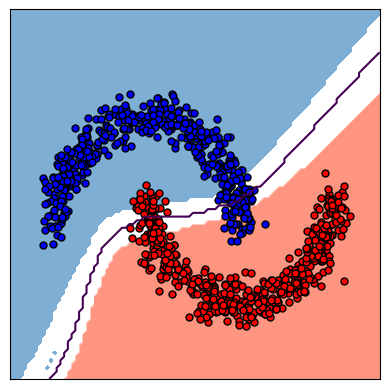

In [34]:
from matplotlib.colors import ListedColormap
N=20
M=5
s=5
### Visualise the results (AGT)
fig, ax = plt.subplots()
ax.set_box_aspect(1)
ax.set_xticks([])
ax.set_yticks([])

ensemble_preds = torch.load(f".results/ensemble_preds_agt_dpa_{N}_{M}_{s}.pth", map_location=device)        
agt_uncert = torch.tensor(torch.load(f".results/moons_agt_p_k={N}_{M}_{s}.pth")['z']).to(device)
preds = ensemble_preds.reshape(gridsize, gridsize).cpu().numpy()
ax.contour(X0, X1, preds, levels=[0.5])
cert_preds_0 = ((ensemble_preds == 0) & (agt_uncert == 0)).float()  # where the model always predicts class 0
cert_preds_1 = ((ensemble_preds == 1) & (agt_uncert == 0)).float()  # where the model always predicts class 1
cert_preds = (cert_preds_0 - cert_preds_1).reshape(gridsize, gridsize).cpu().numpy()
print((cert_preds == 0).sum())
pastel_red = "#FE2C02"   # Soft pinkish-red
pastel_blue = "#015FAA"  # Light pastel blue
cmap = ListedColormap([pastel_red, "white", pastel_blue])
ax.contourf(X0, X1, cert_preds, cmap=cmap, levels=[-1.5, -0.5, 0.0, 0.5, 1.5], alpha=0.5)

# plot the moons
ax.scatter(x_test.cpu()[y_test.cpu() == 0, 0], x_test.cpu()[y_test.cpu() == 0, 1], s=25, edgecolors="k", color="blue")
ax.scatter(x_test.cpu()[y_test.cpu() == 1, 0], x_test.cpu()[y_test.cpu() == 1, 1], s=25, edgecolors="k", color="red")

# save fig
# plt.savefig(f"../figures/agt_moons_{N}_{M}_{s}_fixed_10k.pdf", dpi=300, bbox_inches='tight')

tensor([2., 2., 2.,  ..., 2., 2., 2.])
tensor([[12., 12., 12.,  ...,  2.,  2.,  2.],
        [17., 17., 17.,  ..., 12., 12., 17.],
        [21., 21., 21.,  ...,  2.,  2.,  2.],
        [ 2.,  2.,  2.,  ...,  7., 12., 12.],
        [21., 21., 21.,  ..., 12., 17., 17.]])
tensor([[ 2.,  2.,  2.,  ...,  2.,  2.,  2.],
        [12., 12., 12.,  ...,  2.,  2.,  2.],
        [17., 17., 17.,  ...,  7., 12., 12.],
        [21., 21., 21.,  ..., 12., 12., 17.],
        [21., 21., 21.,  ..., 12., 17., 17.]])
tensor([15., 15., 15.,  ...,  5.,  5.,  5.])
tensor(2142)
tensor(0.2142)
2142


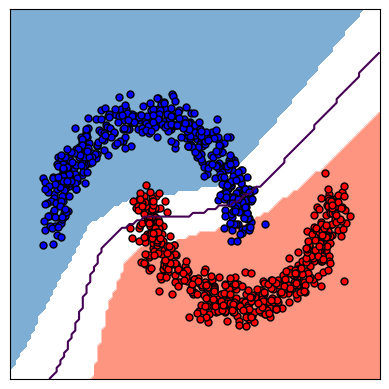

In [36]:
from matplotlib.colors import ListedColormap
# Plot per sample graph
N=20
M=5
s=5
### Visualise the results (AGT)
fig, ax = plt.subplots()
ax.set_box_aspect(1)
ax.set_xticks([])
ax.set_yticks([])

gs = torch.load(f".results/g_{N}_{M}_{s}.pth", map_location=device)
print(gs)

ensemble_preds = torch.load(f".results/ensemble_preds_agt_dpa_{N}_{M}_{s}.pth", map_location=device)
bs = torch.load(f".results/moons_agt_bs_{N}_{M}_{s}.pth", map_location=device)
print(bs)

# compute stable distance for each test datapoint (adversary must poison >= stable_distance points before prediction flips for this data point)
sorted_bs, _ = torch.sort(bs, dim=0)
print(sorted_bs)

# for each test datapoint i (column), try to flip the prediction of the first #gs[i] members
# Stable distance: max number of points that can be poisoned before ensemble prediction flips
stable_distance = torch.tensor([
    max((sorted_bs[:int(k), i] + 1).sum() - 1, 0)
    for i, k in enumerate(gs)
])

print(stable_distance)

# point is accurately predicted if stable distance > N
accurate_points = stable_distance < N
point_wise_accuracy = accurate_points.sum()
print(point_wise_accuracy)

# Percentage
accuracy = point_wise_accuracy.float() / len(stable_distance)

print(accuracy)
preds = ensemble_preds.reshape(gridsize, gridsize).cpu().numpy()
ax.contour(X0, X1, preds, levels=[0.5])
cert_preds_0 = ((ensemble_preds == 0) & (accurate_points == 0)).float()  # where the model always predicts class 0
cert_preds_1 = ((ensemble_preds == 1) & (accurate_points == 0)).float()  # where the model always predicts class 1
cert_preds = (cert_preds_0 - cert_preds_1).reshape(gridsize, gridsize).cpu().numpy()
print((cert_preds == 0).sum())
pastel_red = "#FE2C02"   # Soft pinkish-red
pastel_blue = "#015FAA"  # Light pastel blue
cmap = ListedColormap([pastel_red, "white", pastel_blue])
ax.contourf(X0, X1, cert_preds, cmap=cmap, levels=[-1.5, -0.5, 0.0, 0.5, 1.5], alpha=0.5)

# plot the moons
ax.scatter(x_test.cpu()[y_test.cpu() == 0, 0], x_test.cpu()[y_test.cpu() == 0, 1], s=25, edgecolors="k", color="blue")
ax.scatter(x_test.cpu()[y_test.cpu() == 1, 0], x_test.cpu()[y_test.cpu() == 1, 1], s=25, edgecolors="k", color="red")

# save fig
plt.savefig(f"../figures/agt_moons_{N}_{M}_{s}_per_sample.pdf", dpi=300, bbox_inches='tight')